In [4]:
from google.colab import drive
import pandas as pd

# This will prompt for authorization to access your Google Drive
drive.mount('/content/drive')

# Update the file path to the location where you uploaded your CSV in Google Drive
file_path = '/content/drive/My Drive/Thesis/df-BERT_cat.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Drop the first column (if it's an unwanted index column)
df = df.drop(df.columns[0], axis=1)

# Display the column names
df.columns.tolist()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['numerical_price',
 'embeddings',
 'num_bedrooms',
 'num_rooms',
 'building_type_Bestaande bouw',
 'building_type_Nieuwbouw',
 'building_type_na',
 'tag_k.k.',
 'tag_v.o.n.',
 'house_category_Appartement',
 'house_category_Bungalow',
 'house_category_Eengezinswoning',
 'house_category_Grachtenpand',
 'house_category_Herenhuis',
 'house_category_Landhuis',
 'house_category_Other',
 'house_category_Unknown',
 'house_category_Villa',
 'house_category_Woonboerderij',
 'house_category_Woonboot',
 'energy_label_encoded',
 'size_scaled',
 'longitude_scaled',
 'latitude_scaled']

In [5]:
import pandas as pd
import numpy as np
from ast import literal_eval


df["embeddings"] = df["embeddings"].apply(literal_eval).apply(np.array)

# Separating the target variable and embeddings
x = df["embeddings"]
y = df['numerical_price']

# Dropping the 'ada_embedding_eng' column from df
z = df.drop(["embeddings", "numerical_price"], axis=1)


# Deleting original dataframe for memory purpose
del df

# Explode the embedding arrays into separate columns
x = x.apply(pd.Series)

# Concatenating the exploded embeddings with the rest of the data
concatenated_df = pd.concat([x, z], axis=1).reset_index(drop=True)

In [6]:
concatenated_df.columns = concatenated_df.columns.astype(str)

In [7]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(concatenated_df, y, test_size=0.2, random_state=42)
# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]



In [8]:
!pip install optuna
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_rf_cat(trial):
    # Parameters
    max_depth = trial.suggest_int("max_depth", 2, 50, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
    max_features = trial.suggest_categorical("max_features", ['log2', 'sqrt',])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 25, step=2)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 25, step=2)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    rf_params = dict(max_depth=max_depth, n_estimators=n_estimators,
                     max_features=max_features, min_samples_leaf=min_samples_leaf,
                     min_samples_split=min_samples_split, bootstrap=bootstrap)

    clf_rf_opt = RandomForestRegressor(**rf_params, n_jobs=-1)

    # StandardScaler for y
    scaler = StandardScaler()

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Scaling y_train
        y_train_scaled = scaler.fit_transform(np.array(y_train_fold).reshape(-1, 1)).flatten()


        # Fitting the model
        clf_rf_opt.fit(X_train_fold, y_train_scaled)

        # Predicting and inverse transformation
        y_pred_scaled = clf_rf_opt.predict(X_test_fold)
        y_pred = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()


        # R2 Score
        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)

    return float(np.mean(r2_scores))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.7 MB/s eta 0:00:00


In [9]:
study_rf = optuna.create_study(directions=['maximize'])
study_rf.optimize(Objective_rf_cat, n_trials=50)

[I 2024-01-07 13:08:44,545] A new study created in memory with name: no-name-cc87dd00-1382-4273-86fb-119ba03e60cc
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [2, 25] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 24].
  warnings.warn(
[I 2024-01-07 13:10:45,418] Trial 0 finished with value: 0.3680807392278215 and parameters: {'max_depth': 15, 'n_estimators': 150, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 10, 'bootstrap': True}. Best is trial 0 with value: 0.3680807392278215.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [2, 25] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 24].
  warnings.warn(
[I 2024-01-07 13:12:40,174] Trial 1 finished with value: 0.2804441997300854 and parameters: {'max_depth': 5, 'n_estimators': 200, 'max_features': 'sqrt', 'min_sam

<ipython-input-10-934d0b211bde>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

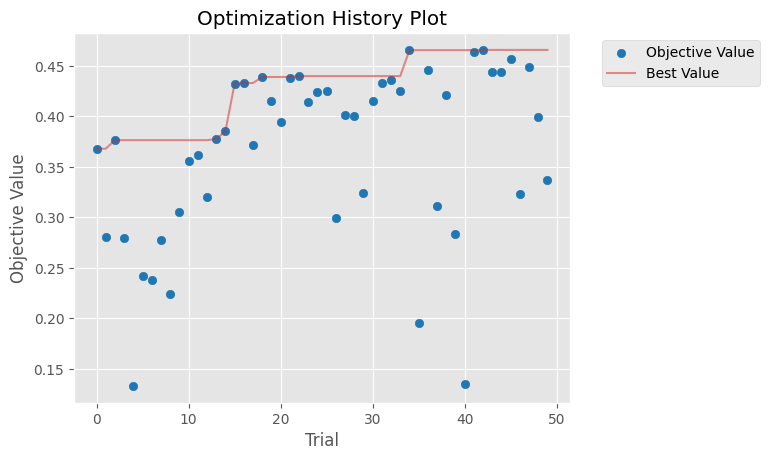

In [10]:
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

<ipython-input-11-1eb49e18946d>:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)
<ipython-input-11-1eb49e18946d>:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_rf)


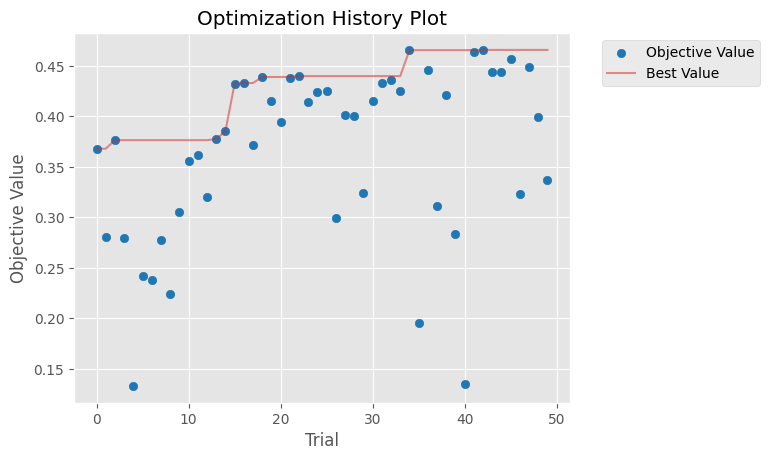

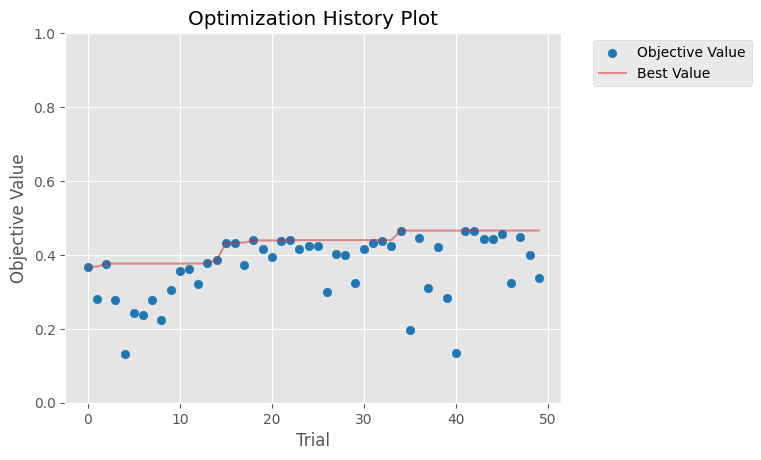

In [11]:
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
# Plot the optimization history in a different format
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

optuna_matplotlib.plot_optimization_history(study_rf)

plt.ylim(0, 1)

plt.show()